# Bag of Words Meets Bags of Popcorn

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from utils import *

%matplotlib inline

### Data

In [3]:
data = pd.read_csv('kg-data/labeledTrainData.tsv', sep='\t')
# data = shuffle(data)
data.shape

(25000, 3)

In [4]:
review_len = pd.Series([len(split_sentence(x)) for x in data['review']], name='ntokens')
data['ntokens'] = review_len

In [5]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
ntokens      25000 non-null int64
dtypes: int64(2), object(2)
memory usage: 781.3+ KB


,id,sentiment,review,ntokens
0,5814_8,1,With all this stuff going down at the moment w...,497
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",190
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,436
3,3630_4,0,It must be assumed that those who praised this...,461
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,423


283

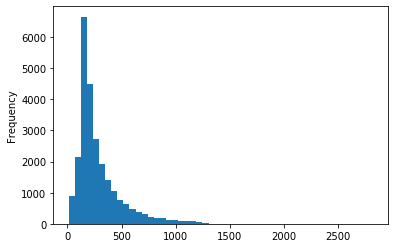

In [11]:
ax = data['ntokens'].plot.hist(bins=50)
int(data['ntokens'].mean())

In [14]:
idx = np.random.randint(len(data))
data.iloc[idx]

id                                                     7452_10
sentiment                                                    1
review       I am a big fan a Faerie Tale Theatre and I've ...
ntokens                                                    168
Name: 6074, dtype: object

In [15]:
X = data['review'].values
Y = data['sentiment'].values

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)

In [104]:
# max_len = 150
max_len = int(data['ntokens'].mean())

print("max len: " + str(max_len))

max len: 283


### Preprocessing

In [18]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import regex as re

In [19]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

In [22]:
ltd = pd.read_csv('kg-data/labeledTrainData.tsv', sep='\t')
ltd = ltd.drop('sentiment', axis=1)
utd = pd.read_csv('kg-data/unlabeledTrainData.tsv', sep='\t', error_bad_lines=False)
corpus = pd.concat([ltd, utd])
corpus.info()
corpus.head()

b'Skipping line 43043: expected 2 fields, saw 3\n'


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74998 entries, 0 to 49997
Data columns (total 2 columns):
id        74998 non-null object
review    74998 non-null object
dtypes: object(2)
memory usage: 1.7+ MB


,id,review
0,5814_8,With all this stuff going down at the moment w...
1,2381_9,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,The film starts with a manager (Nicholas Bell)...
3,3630_4,It must be assumed that those who praised this...
4,9495_8,Superbly trashy and wondrously unpretentious 8...


In [ ]:
# corpus['review'] = corpus['review'].apply(lambda x: clean_text(x))

In [23]:
corpus.head()

,id,review
0,5814_8,With all this stuff going down at the moment w...
1,2381_9,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,The film starts with a manager (Nicholas Bell)...
3,3630_4,It must be assumed that those who praised this...
4,9495_8,Superbly trashy and wondrously unpretentious 8...


In [24]:
texts = corpus['review'].values

### Embeddings

In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [65]:
vocab_len = 100_000
emb_size = 50

In [27]:
tokenizer = Tokenizer(num_words=vocab_len, lower=True, split=' ')
tokenizer.fit_on_texts(texts)

In [28]:
def encode_sentences(sentences):
    tokens = tokenizer.texts_to_sequences(sentences)
    indices = pad_sequences(tokens, maxlen=max_len)
    return indices

### Model

In [29]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [92]:
def MyModel_v1():
    indices = Input(shape=(max_len,), dtype='int32')
    X = Embedding(vocab_len, emb_size)(indices)
    X = LSTM(32, return_sequences = True)(X)
    X = Dropout(0.5)(X)    
    X = LSTM(32)(X)
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=indices, outputs=X)
    return model

In [40]:
def MyModel_v2():
    indices = Input(shape=(max_len,), dtype='int32')
    X = Embedding(vocab_len, emb_size)(indices)
    X = Bidirectional(LSTM(32, return_sequences = True))(X)
    X = GlobalMaxPool1D()(X)
    X = Dense(20, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=indices, outputs=X)
    return model

### Compile & fit

In [93]:
del model

In [94]:
model = MyModel_v1()
# model = MyModel_v2()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 283)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 283, 50)           5000000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 283, 32)           10624     
_________________________________________________________________
dropout_11 (Dropout)         (None, 283, 32)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total para

In [95]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [96]:
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
mc = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)

In [97]:
history = model.fit(encode_sentences(X_train), Y_train, batch_size=64, epochs=100, \
                    callbacks=[es, mc], validation_split=0.1)

Train on 20250 samples, validate on 2250 samples
Epoch 1/100
20250/20250 [==============================] - 159s 8ms/step - loss: 0.5041 - acc: 0.7507 - val_loss: 0.4547 - val_acc: 0.7951

Epoch 00001: val_acc improved from -inf to 0.79511, saving model to model.h5
Epoch 2/100
20250/20250 [==============================] - 160s 8ms/step - loss: 0.2533 - acc: 0.9053 - val_loss: 0.3437 - val_acc: 0.8676

Epoch 00002: val_acc improved from 0.79511 to 0.86756, saving model to model.h5
Epoch 3/100
20250/20250 [==============================] - 157s 8ms/step - loss: 0.1377 - acc: 0.9560 - val_loss: 0.3394 - val_acc: 0.8618

Epoch 00003: val_acc did not improve from 0.86756
Epoch 4/100
20250/20250 [==============================] - 154s 8ms/step - loss: 0.0702 - acc: 0.9796 - val_loss: 0.4499 - val_acc: 0.8542

Epoch 00004: val_acc did not improve from 0.86756
Epoch 5/100
20250/20250 [==============================] - 153s 8ms/step - loss: 0.0468 - acc: 0.9874 - val_loss: 0.6080 - val_acc: 0.

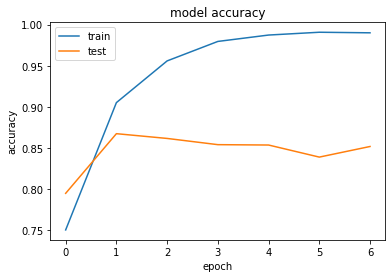

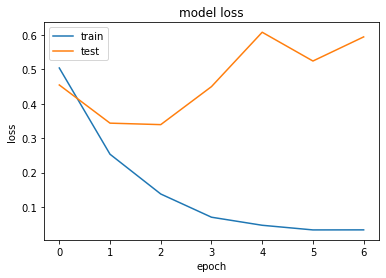

In [98]:
plot_model_accuracy(history)
plot_model_loss(history)

In [102]:
loss, acc = model.evaluate(encode_sentences(X_test), Y_test)
print("Test loss = ", loss)
print("Test accuracy = ", acc)

2500/2500 [==============================] - 7s 3ms/step
Test loss =  0.3147241686940193
Test accuracy =  0.88


### Load model

In [101]:
del model

model = load_model('model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 283)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 283, 50)           5000000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 283, 32)           10624     
_________________________________________________________________
dropout_11 (Dropout)         (None, 283, 32)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total para

### Submission

In [85]:
sub_test = pd.read_csv('kg-data/testData.tsv', sep='\t')
sub_test.shape

(25000, 2)

In [86]:
sub_test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [87]:
X_sub_test = sub_test['review'].values

In [88]:
Y_sub_pred = model.predict(encode_sentences(X_sub_test)).flatten()
Y_sub_pred = (Y_sub_pred > 0.5).astype(int)

In [89]:
ids = sub_test['id']
labels = pd.Series(Y_sub_pred, name="sentiment")
submission = pd.concat([ids, labels], axis=1)
submission.head()

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [90]:
submission.to_csv('kg-data/submission.csv', sep=',', index=False)

### Kaggle

In [ ]:
!kaggle competitions download -c word2vec-nlp-tutorial -p 'kg-data'

In [91]:
!kaggle competitions submit -c word2vec-nlp-tutorial -f 'kg-data/submission.csv' -m '<None>'

100%|████████████████████████████████████████| 227k/227k [00:06<00:00, 33.3kB/s]
Successfully submitted to Bag of Words Meets Bags of Popcorn